In [2]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import sys 
import cv2 
from PIL import Image, ImageDraw
from typing import List, Tuple
import jpeg4py

sys.path.append("..")
from data_loader.mhp_utils import get_category, load_anns
from evaluate_tflite import TFLiteModel

In [3]:
data_dir='../datasets/LV-MHP-v2'
data_type='val'
ann_file='{}/{}/lv_mhp_{}_keypoints.json'.format(data_dir, data_type, data_type)
ann_file = '{}/{}/lv_mhp_{}_keypoints_kp_16_iou_20.json'.format(data_dir,data_type, data_type)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
/home/edelbert/Desktop/work/test/tf2-mobile-2d-single-pose-estimation/datasets/LV-MHP-v2/val/filtered_croped_images/12971_1.jpg


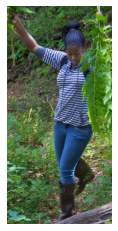

In [4]:
coco = COCO(ann_file)
catIds = coco.getCatIds(catNms=['person'])
imgIds = coco.getImgIds(catIds=catIds )
#1310 #1 # 7 
img_info = coco.loadImgs(imgIds[7])[0]
annIds = coco.getAnnIds(imgIds=img_info['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
print(img_info['coco_url'])
img = jpeg4py.JPEG(img_info['coco_url']).decode()
#img = cv2.imread(img_info['coco_url'])
#show image
plt.axis('off')
plt.imshow(img)
plt.show()

In [5]:
def convert_heatmap_to_keypoint(heatmap, image_size):
    # heatmap = gaussian_filter(heatmap, sigma=5)
    idx = np.unravel_index(np.argmax(heatmap), heatmap.shape)
    x_idx = idx[1] / heatmap.shape[1]
    y_idx = idx[0] / heatmap.shape[0]
    #print('xm y', x_idx, y_idx)
    return int(x_idx * image_size[1]), int(y_idx * image_size[0]) # exchange y, x sequence

def convert_heatmaps_to_keypoints(heatmaps, image_size):
    kp_num = heatmaps.shape[-1]
    #print(kp_num)
    return [convert_heatmap_to_keypoint(heatmaps[:, :, kp_index], image_size) for kp_index in range(kp_num)]

def scale_image_and_pose(image_, output_size, pose_, mean):
    h, w = image_.shape[:2]
    im_scale = min(float(output_size[0]) / float(h), float(output_size[1]) / float(w))
    new_h = int(image_.shape[0] * im_scale)
    new_w = int(image_.shape[1] * im_scale)
    image = cv2.resize(image_, (new_w, new_h),
                interpolation=cv2.INTER_LINEAR)
    left_pad = (output_size[1] - new_w) // 2
    right_pad = (output_size[1] - new_w) - left_pad
    top_pad = (output_size[0] - new_h) // 2
    bottom_pad = (output_size[0] - new_h) - top_pad
    pad = ((top_pad, bottom_pad), (left_pad, right_pad))
    image = np.stack([np.pad(image[:,:,c], pad, mode='constant', constant_values=mean[c]) 
                    for c in range(3)], axis=2)
    pose = (pose_.reshape([-1,2])/np.array([w,h])*np.array([new_w,new_h]))
    pose += [left_pad, top_pad]
    return image, pose, new_w, new_h, left_pad, top_pad

def network_inference(tflite_model: str, img: np.ndarray, pose) -> List[Tuple]:
    model = TFLiteModel(tflite_model_path = tflite_model,
                        output_index=-1)
    h, w = img.shape[:2]
    input_image = img.astype(np.float32) / 256.0
    mean = np.array([0.485, 0.456, 0.406]).astype(np.float32)
    std = np.array([0.229, 0.224, 0.225]).astype(np.float32)
    
    resized_image, _pose, new_w, new_h, left_pad, top_pad = scale_image_and_pose(input_image, (model.input_shape[1], model.input_shape[2]), np.array(pose), mean)
    input_image = resized_image.copy()

    input_image = (input_image - mean)/ std

    input_image = np.expand_dims(input_image, axis=0)
    pred_heatmaps = model.inference(input_image)
    pred_heatmaps = np.squeeze(pred_heatmaps)
    number_of_keypoints = pred_heatmaps.shape[-1]
    pred_coords = np.asarray(convert_heatmaps_to_keypoints(pred_heatmaps, resized_image.shape))
    pred_coords -= [left_pad, top_pad]
    
    pred_coords = (pred_coords.reshape([-1,2]) / np.array([new_w, new_h]) * np.array([w,h]))
    return pred_coords, resized_image, pose

def gt_points_to_tuple(points: List[float]) -> List[Tuple]:
    output = []
    for x, y, v in zip(points[0::3], points[1::3], points[2::3]):
        if v == 2:
            output.append((int(x), int(y)))
    return output
    
def draw_points(points: List[Tuple], img: np.ndarray, radius:int = 5) -> np.ndarray:
    canvas = img.copy()
    
    for i, p in enumerate(points):
        if not isinstance(p, tuple):
            p = (int(p[0]), int(p[1]))
        cv2.circle(canvas, p, radius, [0,0,255], -1)
        cv2.putText(canvas, f'{i}', p, cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0,255,0), 1)
    return canvas
    
def draw_results(pred_points: List[Tuple], gt_points: List[float], img: np.ndarray, figsize : Tuple[int] = (18, 16)) -> None:
    #draw on gt on image
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    pred_canvas = draw_points(pred_points, img)
    
    #gt_points = gt_points_to_tuple(gt_points)
    gt_canvas = draw_points(gt_points, img)
    
    fig = plt.figure(figsize = figsize)
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(pred_canvas)
    ax1.set_title('predicted points')
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(gt_canvas)
    ax2.set_title('gt points')
    fig.tight_layout()
    
    plt.show()
    

In [6]:
print(anns[0])

{'keypoints': [216.75, 452.25999999999993, 2, 145.07, 433.48999999999995, 2, 134.82999999999998, 315.72999999999996, 2, 196.26999999999998, 314.02000000000004, 2, 167.25, 431.78000000000003, 2, 168.95999999999998, 544.4200000000001, 2, 162.13, 314.02000000000004, 2, 175.79000000000002, 209.92000000000002, 2, 182.61, 165.53999999999996, 2, 177.49, 66.56, 2, 27.310000000000002, 49.49000000000001, 2, 64.85000000000002, 112.63999999999999, 2, 141.64999999999998, 138.24, 2, 218.45, 160.42000000000002, 2, 273.07, 119.45999999999998, 2, 267.95, 54.610000000000014, 2], 'category_id': 1, 'num_keypoints': 16, 'image_id': 7, 'old_image_id': 12971, 'bbox': [194.56, 293.55, 286.72, 597.33], 'id': 7, 'area': 171266.45760000002, 'iscrowd': 0}


In [7]:
#perform inference
gt_pose = gt_points_to_tuple(anns[0]['keypoints'])
model_path = '../logs/coco_single-experiment001/LV-MHP-v2/04222129_hourglass_hg/tflite/04222129_hourglass_hg-175000.tflite'
#model_path = '../logs/coco_single-experiment001/LV-MHP-v2/04242246_blazepose_full_hg/tflite/04242246_blazepose_full_hg-191500.tflite'
pred_points, resized_image, pose = network_inference(model_path, img, gt_pose)
#resized_image = resized_image / 256.0
print('predicted', pred_points,  'original ', pose)

model loaded
[{'name': 'input_1', 'index': 0, 'shape': array([  1, 192, 192,   3], dtype=int32), 'shape_signature': array([  1, 192, 192,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
output_details: [ 1 48 48 16]
predicted [[157.14285714 547.25      ]
 [157.14285714 447.75      ]
 [132.         323.375     ]
 [207.42857143 310.9375    ]
 [169.71428571 435.3125    ]
 [157.14285714 534.8125    ]
 [169.71428571 310.9375    ]
 [194.85714286 174.125     ]
 [182.28571429 136.8125    ]
 [182.28571429  62.1875    ]
 [ 18.85714286  62.1875    ]
 [ 69.14285714 124.375     ]
 [144.57142857 136.8125    ]
 [207.42857143 161.6875    ]
 [232.57142857 248.75      ]
 [207.42857143 161.6875    ]] original  [(216, 452), (145, 433), (134, 315), (196, 314), (167, 431), (168, 544), (162, 314), (175, 209), (182, 165), 

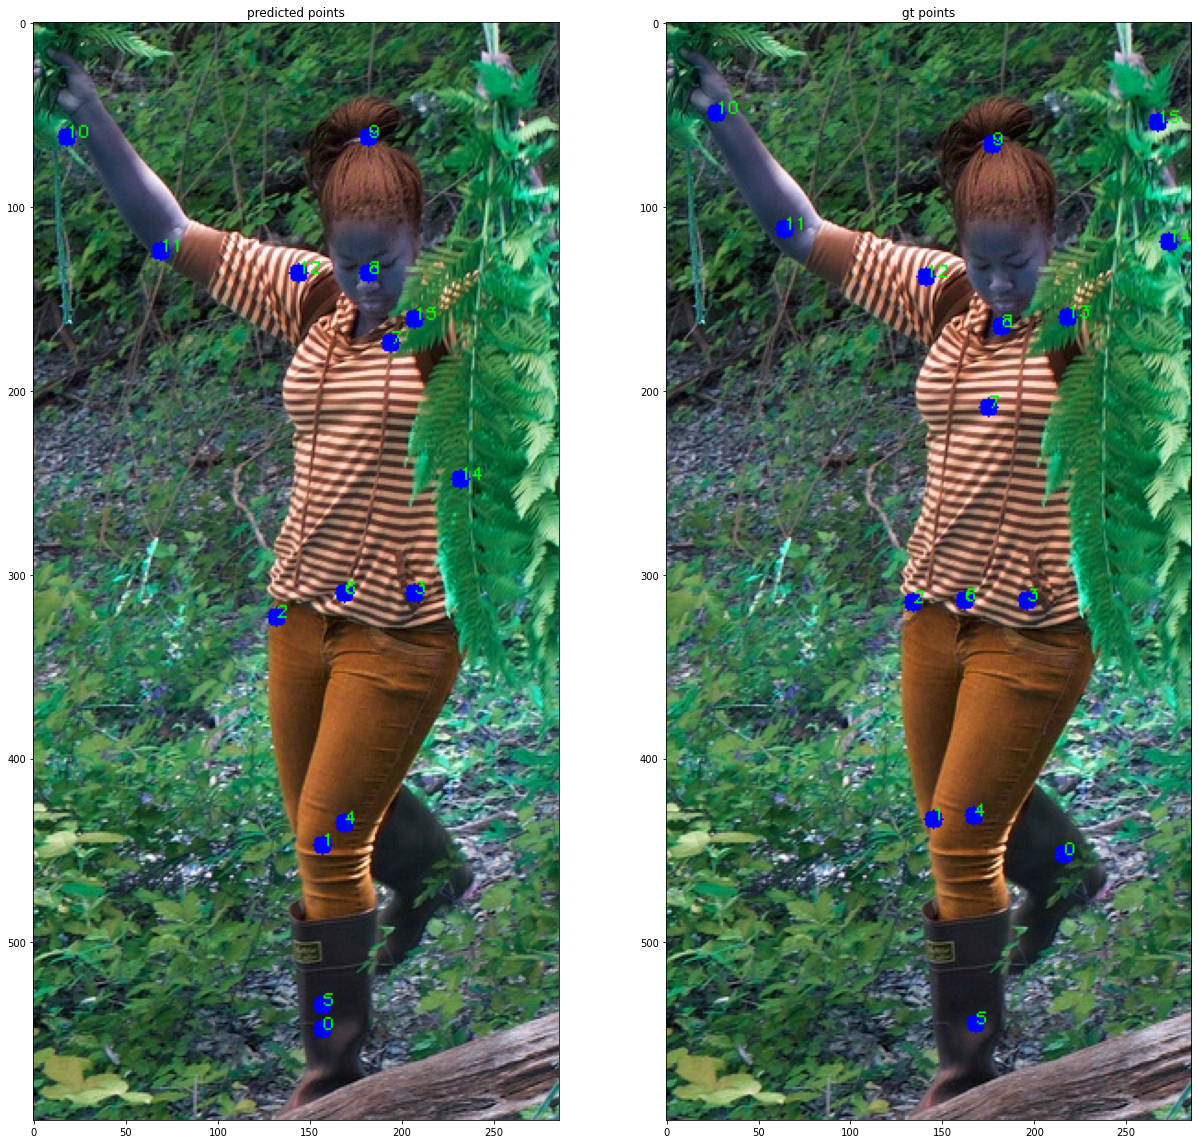

In [8]:
draw_results(pred_points, pose, img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


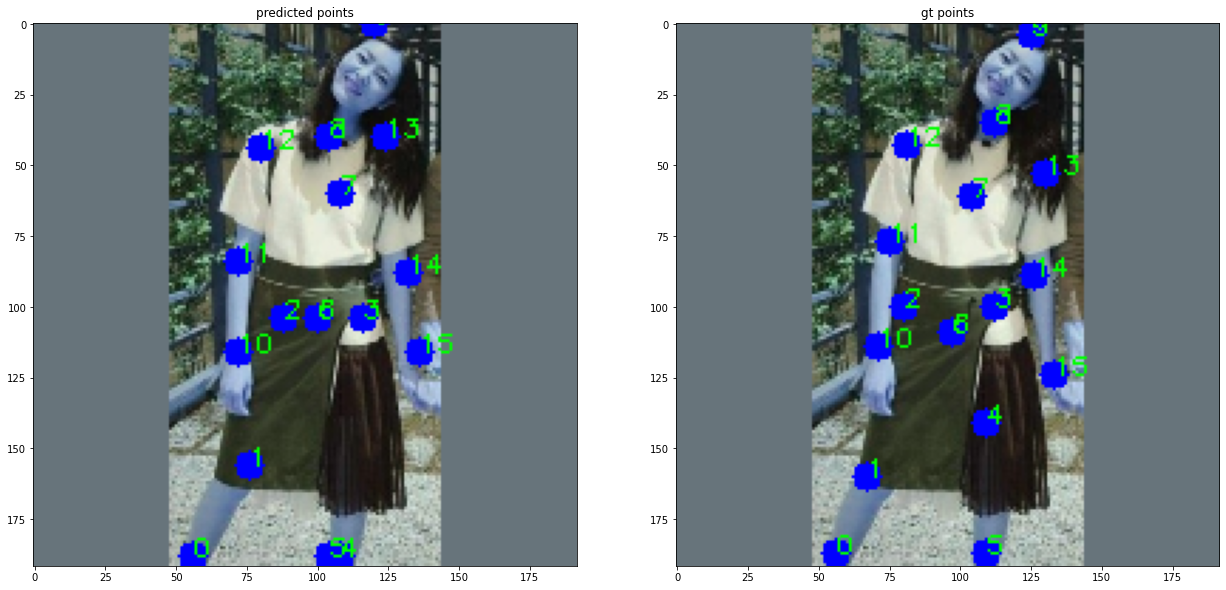

In [42]:
draw_results(pred_points, pose, resized_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


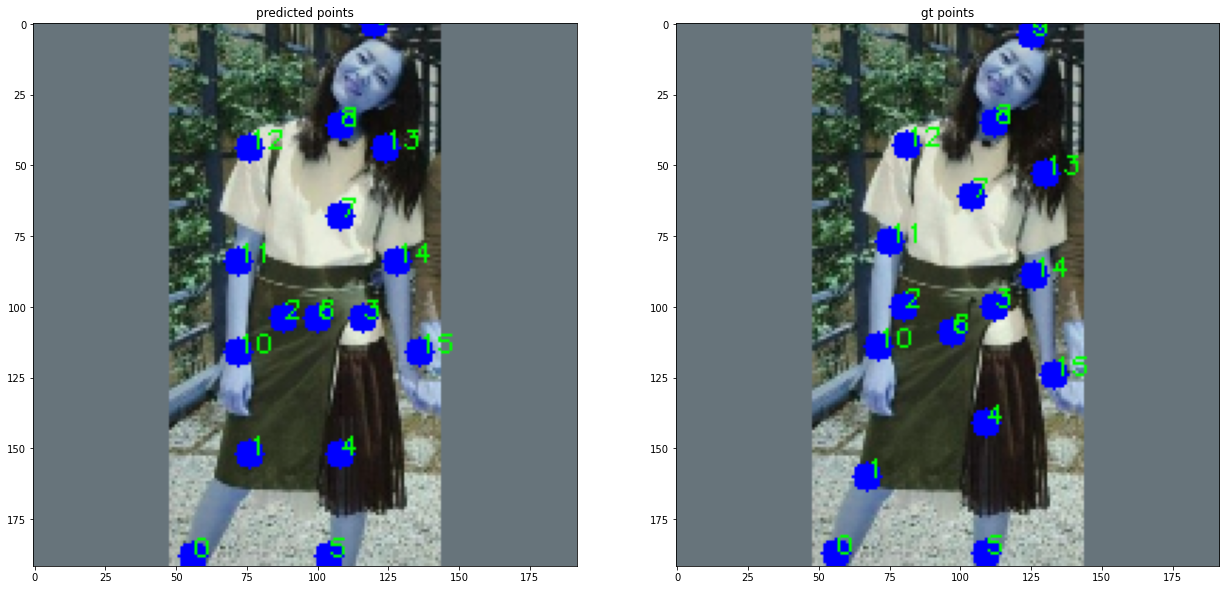

In [10]:
draw_results(pred_points, pose, resized_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


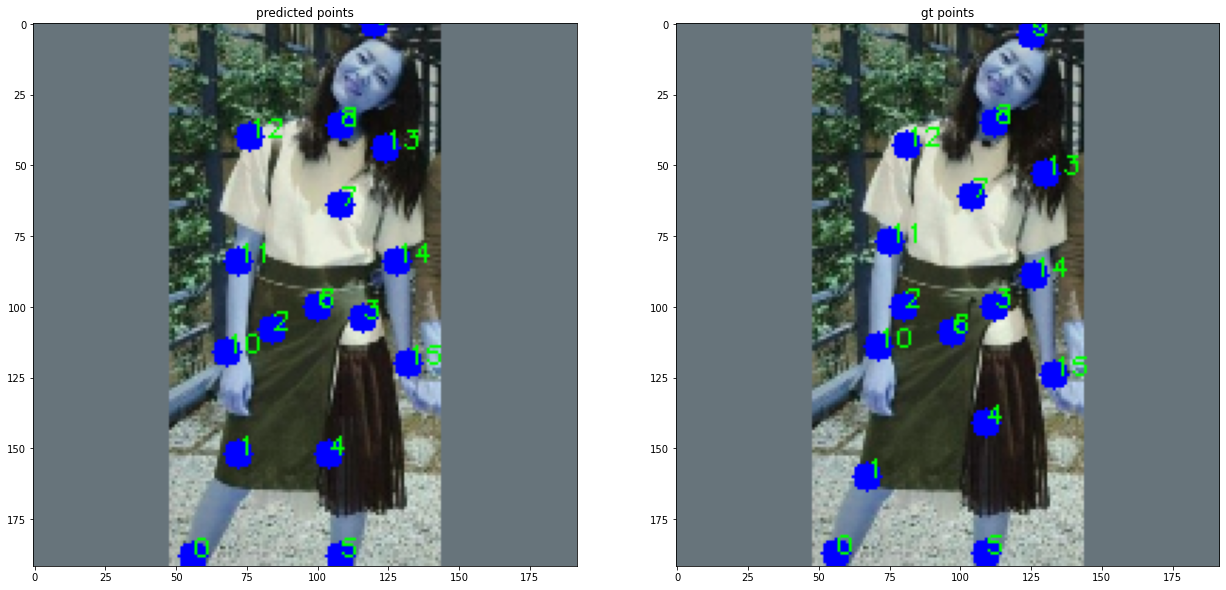

In [55]:
draw_results(pred_points, pose, resized_image)